## Importación de librerías

In [ ]:
import pandas as pd
import numpy as np
# !pip install wordcloud
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Usando pyspark

In [ ]:
!pip install pyspark

In [ ]:
!pip install pyspark_dist_explore

In [ ]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import count, desc
from pyspark.sql.functions import countDistinct
from pyspark.sql.functions import first
from pyspark.sql.functions import count, sum, when, col, lit
from pyspark.sql.functions import split, explode, trim
from pyspark_dist_explore import hist
import pyspark.sql.functions as F
from pyspark.sql.functions import to_date, min, max

In [ ]:
spark = SparkSession.builder \
        .appName("MiApp") \
        .config("spark.driver.memory", "8g") \
        .config("spark.executor.memory", "8g") \
        .getOrCreate()

## ```reviews.json```

In [ ]:
path = '/content/drive/MyDrive/Colab Notebooks/PF/Yelp/review.json'
reviews = spark.read.json(path)

In [ ]:
reviews.limit(5).show()

+--------------------+----+-------------------+-----+--------------------+-----+--------------------+------+--------------------+
|         business_id|cool|               date|funny|           review_id|stars|                text|useful|             user_id|
+--------------------+----+-------------------+-----+--------------------+-----+--------------------+------+--------------------+
|XQfwVwDr-v0ZS3_Cb...|   0|2018-07-07 22:09:11|    0|KU_O5udG6zpxOg-Vc...|  3.0|If you decide to ...|     0|mh_-eMZ6K5RLWhZyI...|
|7ATYjTIgM3jUlt4UM...|   1|2012-01-03 15:28:18|    0|BiTunyQ73aT9WBnpR...|  5.0|I've taken a lot ...|     1|OyoGAe7OKpv6SyGZT...|
|YjUWPpI6HXG530lwP...|   0|2014-02-05 20:30:30|    0|saUsX_uimxRlCVr67...|  3.0|Family diner. Had...|     0|8g_iMtfSiwikVnbP2...|
|kxX2SOes4o-D3ZQBk...|   1|2015-01-04 00:01:03|    0|AqPFMleE6RsU23_au...|  5.0|Wow!  Yummy, diff...|     1|_7bHUi9Uuf5__HHc_...|
|e4Vwtrqf-wpJfwesg...|   1|2017-01-14 20:54:15|    0|Sx8TMOWLNuJBWer-0...|  4.0|Cute inter

In [ ]:
reviews.printSchema()

root
 |-- business_id: string (nullable = true)
 |-- cool: long (nullable = true)
 |-- date: string (nullable = true)
 |-- funny: long (nullable = true)
 |-- review_id: string (nullable = true)
 |-- stars: double (nullable = true)
 |-- text: string (nullable = true)
 |-- useful: long (nullable = true)
 |-- user_id: string (nullable = true)



In [ ]:
# Tupla con la cantidad de registros y columnas presentes en "reviews"
(reviews.count(), len(reviews.columns))

(6990280, 9)

### Datos faltantes

In [ ]:
# contar valores faltantes por columna
missing_values_count = reviews.select([count(when(col(c).isNull(), c)).alias(c) for c in reviews.columns])

# agregar una columna con el total de filas
missing_values_count = missing_values_count.withColumn("total_rows", lit(reviews.count()))

# calcular el porcentaje faltante
missing_percentage = missing_values_count.select([((col(c) / col("total_rows")) * 100).alias(c) for c in reviews.columns])

missing_percentage.show()

+-----------+----+----+-----+---------+-----+----+------+-------+
|business_id|cool|date|funny|review_id|stars|text|useful|user_id|
+-----------+----+----+-----+---------+-----+----+------+-------+
|        0.0| 0.0| 0.0|  0.0|      0.0|  0.0| 0.0|   0.0|    0.0|
+-----------+----+----+-----+---------+-----+----+------+-------+



In [ ]:
# % de datos faltantes respecto al total de los datos presentes en "reviews"
missing_values_count = reviews.select([sum(col(c).isNull().cast("int")).alias(c) for c in reviews.columns])

total_cells = reviews.count() * len(reviews.columns)
total_missing = missing_values_count.rdd.flatMap(lambda x: x).sum()
percent_missing = (total_missing / total_cells) * 100
print(f"{round(percent_missing, 2)}%")

0.0%


### Resumen estadístico

In [ ]:
reviews.select('cool', 'funny', 'stars', 'useful').summary().show()

+-------+------------------+-------------------+------------------+------------------+
|summary|              cool|              funny|             stars|            useful|
+-------+------------------+-------------------+------------------+------------------+
|  count|           6990280|            6990280|           6990280|           6990280|
|   mean|0.4986175088837643|0.32655959417934616|  3.74858374771826|1.1846089140921394|
| stddev|2.1724598202111864| 1.6887290985540495|1.4787045052556855| 3.253766966933363|
|    min|                -1|                 -1|               1.0|                -1|
|    25%|                 0|                  0|               3.0|                 0|
|    50%|                 0|                  0|               4.0|                 0|
|    75%|                 0|                  0|               5.0|                 1|
|    max|               404|                792|               5.0|              1182|
+-------+------------------+---------------

### Exploración Univariable

#### Atributo ```date```

In [ ]:
# Convertir la columna "Date" a tipo fecha
df = reviews.withColumn("Date", to_date("Date"))

# Obtener la fecha mínima y máxima en la columna "Date"
min_date = df.select(min("Date")).collect()[0][0]
max_date = df.select(max("Date")).collect()[0][0]

# Imprimir la fecha mínima y máxima
print("Fecha mínima: {}".format(min_date))
print("Fecha máxima: {}".format(max_date))

Fecha mínima: 2005-02-16
Fecha máxima: 2022-01-19


#### Atributo ```cool```

In [ ]:
# Cantidad de comercios únicos en la columna "cool"
cantidad_unicos = reviews.agg({"cool": "approx_count_distinct"}).collect()[0][0]
# mostrar el resultado
print("Número de votos únicos:", cantidad_unicos)

Número de votos únicos: 202


In [ ]:
# Conteo de ocurrencias de cada valor en la columna "cool"
conteo_valores = reviews.groupBy("cool").agg(count("*").alias("conteo")).orderBy("conteo", ascending = False)
# mostrar el resultado
conteo_valores.show()

+----+-------+
|cool| conteo|
+----+-------+
|   0|5377964|
|   1|1016736|
|   2| 296999|
|   3| 114763|
|   4|  56609|
|   5|  32352|
|   6|  21530|
|   7|  15010|
|   8|  11028|
|   9|   8085|
|  10|   6349|
|  11|   4981|
|  12|   4011|
|  13|   3125|
|  14|   2549|
|  15|   2105|
|  16|   1800|
|  17|   1458|
|  18|   1270|
|  19|   1092|
+----+-------+
only showing top 20 rows



#### Atributo ```funny```

In [ ]:
# Cantidad de comercios únicos en la columna "funny"
cantidad_unicos = reviews.agg({"funny": "approx_count_distinct"}).collect()[0][0]
# mostrar el resultado
print("Número de votos únicos:", cantidad_unicos)

Número de votos únicos: 202


In [ ]:
# Conteo de ocurrencias de cada valor en la columna "funny"
conteo_valores = reviews.groupBy("funny").agg(count("*").alias("conteo")).orderBy("conteo", ascending = False)
# mostrar el resultado
conteo_valores.show()

+-----+-------+
|funny| conteo|
+-----+-------+
|    0|5894117|
|    1| 691994|
|    2| 195290|
|    3|  82111|
|    4|  42254|
|    5|  24723|
|    6|  15545|
|    7|  10178|
|    8|   7147|
|    9|   5223|
|   10|   3739|
|   11|   2992|
|   12|   2367|
|   13|   1896|
|   14|   1419|
|   15|   1274|
|   16|   1014|
|   17|    781|
|   18|    694|
|   19|    599|
+-----+-------+
only showing top 20 rows



#### Atributo ```stars```

In [ ]:
# Cantidad de comercios únicos en la columna "stars"
cantidad_unicos = reviews.agg({"stars": "approx_count_distinct"}).collect()[0][0]
# mostrar el resultado
print("Número de puntajes únicos:", cantidad_unicos)

Número de puntajes únicos: 5


In [ ]:
# Conteo de ocurrencias de cada valor en la columna "stars"
conteo_valores = reviews.groupBy("stars").agg(count("*").alias("conteo")).orderBy("conteo", ascending = False)
# mostrar el resultado
conteo_valores.show()

+-----+-------+
|stars| conteo|
+-----+-------+
|  5.0|3231627|
|  4.0|1452918|
|  1.0|1069561|
|  3.0| 691934|
|  2.0| 544240|
+-----+-------+



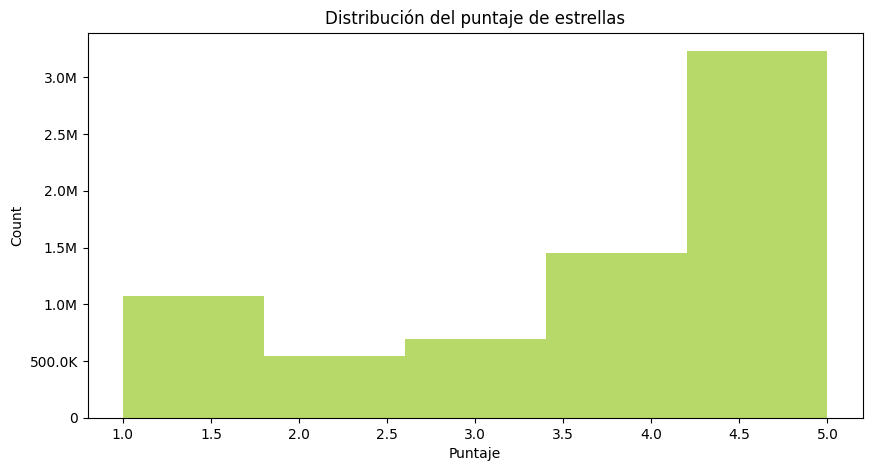

In [ ]:
# Visualizar la distribución de los datos
fig, ax = plt.subplots(figsize = (10, 5))
hist(ax, reviews.select("stars"), bins = 5, color = '#B6D96A')
ax.set_title("Distribución del puntaje de estrellas")
ax.set_xlabel("Puntaje")
ax.set_ylabel("Count")
plt.show()

#### Atributo ```useful```

In [ ]:
# Cantidad de comercios únicos en la columna "useful"
cantidad_unicos = reviews.agg({"useful": "approx_count_distinct"}).collect()[0][0]
# mostrar el resultado
print("Número de votos únicos:", cantidad_unicos)

Número de votos únicos: 254


In [ ]:
# Conteo de ocurrencias de cada valor en la columna "useful"
conteo_valores = reviews.groupBy("useful").agg(count("*").alias("conteo")).orderBy("conteo", ascending = False)
# mostrar el resultado
conteo_valores.show()

+------+-------+
|useful| conteo|
+------+-------+
|     0|3840492|
|     1|1539953|
|     2| 687425|
|     3| 343742|
|     4| 186984|
|     5| 112204|
|     6|  71214|
|     7|  47679|
|     8|  34000|
|     9|  24783|
|    10|  18475|
|    11|  14319|
|    12|  11103|
|    13|   8751|
|    14|   7112|
|    15|   5633|
|    16|   4688|
|    17|   3874|
|    18|   3287|
|    19|   2780|
+------+-------+
only showing top 20 rows



## ```user.parquet```

In [ ]:
path = '/content/drive/MyDrive/Colab Notebooks/PF/Yelp/user.parquet'
user = spark.read.format("parquet").option("header", "true").load(path)

In [ ]:
user.limit(5).show()

+--------------------+------+------------+-------------------+------+-----+-----+--------------------+--------------------+----+-------------+--------------+---------------+------------------+---------------+---------------+---------------+----------------+---------------+----------------+-----------------+-----------------+
|             user_id|  name|review_count|      yelping_since|useful|funny| cool|               elite|             friends|fans|average_stars|compliment_hot|compliment_more|compliment_profile|compliment_cute|compliment_list|compliment_note|compliment_plain|compliment_cool|compliment_funny|compliment_writer|compliment_photos|
+--------------------+------+------------+-------------------+------+-----+-----+--------------------+--------------------+----+-------------+--------------+---------------+------------------+---------------+---------------+---------------+----------------+---------------+----------------+-----------------+-----------------+
|qVc8ODYU5SZjKXVBg.

In [ ]:
user.printSchema()

root
 |-- user_id: string (nullable = true)
 |-- name: string (nullable = true)
 |-- review_count: long (nullable = true)
 |-- yelping_since: string (nullable = true)
 |-- useful: long (nullable = true)
 |-- funny: long (nullable = true)
 |-- cool: long (nullable = true)
 |-- elite: string (nullable = true)
 |-- friends: string (nullable = true)
 |-- fans: long (nullable = true)
 |-- average_stars: double (nullable = true)
 |-- compliment_hot: long (nullable = true)
 |-- compliment_more: long (nullable = true)
 |-- compliment_profile: long (nullable = true)
 |-- compliment_cute: long (nullable = true)
 |-- compliment_list: long (nullable = true)
 |-- compliment_note: long (nullable = true)
 |-- compliment_plain: long (nullable = true)
 |-- compliment_cool: long (nullable = true)
 |-- compliment_funny: long (nullable = true)
 |-- compliment_writer: long (nullable = true)
 |-- compliment_photos: long (nullable = true)



In [ ]:
# Tupla con la cantidad de registros y columnas presentes en "user"
(user.count(), len(user.columns))

(2105597, 22)

### Datos faltantes

In [ ]:
# contar valores faltantes por columna
missing_values_count = user.select([count(when(col(c).isNull(), c)).alias(c) for c in user.columns])

# agregar una columna con el total de filas
missing_values_count = missing_values_count.withColumn("total_rows", lit(user.count()))

# calcular el porcentaje faltante
missing_percentage = missing_values_count.select([((col(c) / col("total_rows")) * 100).alias(c) for c in user.columns])

missing_percentage.show()

+-------+----+------------+-------------+------+-----+----+-----+-------+----+-------------+--------------+---------------+------------------+---------------+---------------+---------------+----------------+---------------+----------------+-----------------+-----------------+
|user_id|name|review_count|yelping_since|useful|funny|cool|elite|friends|fans|average_stars|compliment_hot|compliment_more|compliment_profile|compliment_cute|compliment_list|compliment_note|compliment_plain|compliment_cool|compliment_funny|compliment_writer|compliment_photos|
+-------+----+------------+-------------+------+-----+----+-----+-------+----+-------------+--------------+---------------+------------------+---------------+---------------+---------------+----------------+---------------+----------------+-----------------+-----------------+
|    0.0| 0.0|         0.0|          0.0|   0.0|  0.0| 0.0|  0.0|    0.0| 0.0|          0.0|           0.0|            0.0|               0.0|            0.0|           

In [ ]:
# % de datos faltantes respecto al total de los datos presentes en "user"
missing_values_count = user.select([sum(col(c).isNull().cast("int")).alias(c) for c in user.columns])

total_cells = user.count() * len(user.columns)
total_missing = missing_values_count.rdd.flatMap(lambda x: x).sum()
percent_missing = (total_missing / total_cells) * 100
print(f"{round(percent_missing, 2)}%")

0.0%


### Resumen estadístico

In [ ]:
user.select('review_count', 'useful', 'funny', 'cool', 'fans', 'average_stars').summary().show()

+-------+------------------+------------------+------------------+------------------+------------------+------------------+
|summary|      review_count|            useful|             funny|              cool|              fans|     average_stars|
+-------+------------------+------------------+------------------+------------------+------------------+------------------+
|  count|           2105597|           2105597|           2105597|           2105597|           2105597|           2105597|
|   mean|28.468750192938156|55.168530350299704|   22.676669847079|31.430133116641027|1.9137460777157262| 3.641863428754904|
| stddev|104.21458332104262|  738.806830511282|462.88108202467276| 637.9274190352409| 24.36510499356297|1.1595189372983694|
|    min|                 0|                 0|                 0|                 0|                 0|               1.0|
|    25%|                 2|                 0|                 0|                 0|                 0|               3.0|
|    50%

### Exploración univariable

#### Atributo ```review_count```

In [ ]:
# Cantidad de comercios únicos en la columna "review_count"
cantidad_unicos = user.agg({"review_count": "approx_count_distinct"}).collect()[0][0]
# mostrar el resultado
print("Cantidad de reseñas únicas:", cantidad_unicos)

Cantidad de reseñas únicas: 1883


In [ ]:
# Conteo de ocurrencias de cada valor en la columna "review_count"
conteo_valores = user.groupBy("review_count").agg(count("*").alias("conteo")).orderBy("conteo", ascending = False)
# mostrar el resultado
conteo_valores.show()

+------------+------+
|review_count|conteo|
+------------+------+
|           1|347009|
|           2|245887|
|           3|181512|
|           4|134925|
|           5|104727|
|           6| 84821|
|           7| 70443|
|           8| 59905|
|           9| 52558|
|          10| 46723|
|          11| 41227|
|          12| 37264|
|          13| 33485|
|          14| 30892|
|          15| 28325|
|          16| 25580|
|          17| 23752|
|          18| 21934|
|          19| 20425|
|          20| 18711|
+------------+------+
only showing top 20 rows



#### Atributo ```average_stars```

In [ ]:
# Cantidad de comercios únicos en la columna "average_stars"
cantidad_unicos = user.agg({"average_stars": "approx_count_distinct"}).collect()[0][0]
# mostrar el resultado
print("Promedio de estrellas únicos:", cantidad_unicos)

Promedio de estrellas únicos: 412


In [ ]:
# Conteo de ocurrencias de cada valor en la columna "average_stars"
conteo_valores = user.groupBy("average_stars").agg(count("*").alias("conteo")).orderBy("conteo", ascending = False)
# mostrar el resultado
conteo_valores.show()

+-------------+------+
|average_stars|conteo|
+-------------+------+
|          5.0|360145|
|          1.0|166416|
|          3.0|113462|
|          4.0|106769|
|         3.67| 52087|
|          2.0| 49492|
|          4.5| 41320|
|          3.5| 36460|
|         4.33| 27990|
|         2.33| 26845|
|         4.67| 22343|
|          4.2| 21939|
|         3.33| 18041|
|          2.5| 17743|
|         4.25| 16865|
|         3.75| 16049|
|          3.4| 15064|
|         4.75| 13344|
|         2.67| 13037|
|          3.8| 12476|
+-------------+------+
only showing top 20 rows



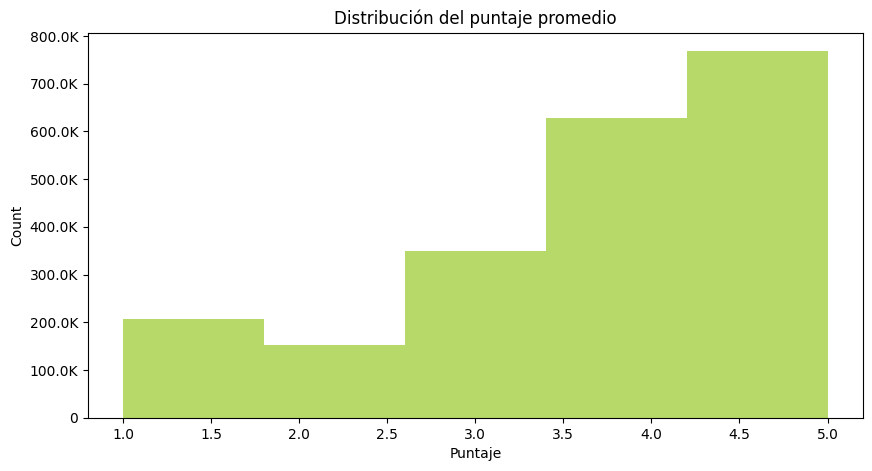

In [ ]:
# Visualizar la distribución de los datos
fig, ax = plt.subplots(figsize = (10, 5))
hist(ax, user.select("average_stars"), bins = 5, color = '#B6D96A')
ax.set_title("Distribución del puntaje promedio")
ax.set_xlabel("Puntaje")
ax.set_ylabel("Count")
plt.show()

## ```business.pk```

In [ ]:
path_2 = '/content/drive/MyDrive/Colab Notebooks/PF/Yelp/business.pkl'
df_businessP = pd.read_pickle(path_2)
df_businessP = df_businessP.iloc[:, :14]
business = spark.createDataFrame(df_businessP)

In [ ]:
business.limit(5).show()

+--------------------+--------------------+--------------------+-------------+-----+-----------+----------+------------+-----+------------+-------+--------------------+--------------------+--------------------+
|         business_id|                name|             address|         city|state|postal_code|  latitude|   longitude|stars|review_count|is_open|          attributes|          categories|               hours|
+--------------------+--------------------+--------------------+-------------+-----+-----------+----------+------------+-----+------------+-------+--------------------+--------------------+--------------------+
|Pns2l4eNsfO8kk83d...|Abby Rappoport, L...|1616 Chapala St, ...|Santa Barbara|  NaN|      93101|34.4266787|-119.7111968|  5.0|           7|      0|{ByAppointmentOnl...|Doctors, Traditio...|                null|
|mpf3x-BjTdTEA3yCZ...|       The UPS Store|87 Grasso Plaza S...|       Affton|  NaN|      63123| 38.551126|  -90.335695|  3.0|          15|      1|{Business

In [ ]:
business.printSchema()

root
 |-- business_id: string (nullable = true)
 |-- name: string (nullable = true)
 |-- address: string (nullable = true)
 |-- city: string (nullable = true)
 |-- state: string (nullable = true)
 |-- postal_code: string (nullable = true)
 |-- latitude: double (nullable = true)
 |-- longitude: double (nullable = true)
 |-- stars: double (nullable = true)
 |-- review_count: long (nullable = true)
 |-- is_open: long (nullable = true)
 |-- attributes: map (nullable = true)
 |    |-- key: string
 |    |-- value: string (valueContainsNull = true)
 |-- categories: string (nullable = true)
 |-- hours: map (nullable = true)
 |    |-- key: string
 |    |-- value: string (valueContainsNull = true)



In [ ]:
# Tupla con la cantidad de registros y columnas presentes en "business"
(business.count(), len(business.columns))

(150346, 14)

### Datos faltantes

In [ ]:
# contar valores faltantes por columna
missing_values_count = business.select([count(when(col(c).isNull(), c)).alias(c) for c in business.columns])

# agregar una columna con el total de filas
missing_values_count = missing_values_count.withColumn("total_rows", lit(business.count()))

# calcular el porcentaje faltante
missing_percentage = missing_values_count.select([((col(c) / col("total_rows")) * 100).alias(c) for c in business.columns])

missing_percentage.show()

+-----------+----+-------+----+-----+-----------+--------+---------+-----+------------+-------+----------------+-------------------+------------------+
|business_id|name|address|city|state|postal_code|latitude|longitude|stars|review_count|is_open|      attributes|         categories|             hours|
+-----------+----+-------+----+-----+-----------+--------+---------+-----+------------+-------+----------------+-------------------+------------------+
|        0.0| 0.0|    0.0| 0.0|  0.0|        0.0|     0.0|      0.0|  0.0|         0.0|    0.0|9.14158008859564|0.06850864007023798|15.446370372341134|
+-----------+----+-------+----+-----+-----------+--------+---------+-----+------------+-------+----------------+-------------------+------------------+



In [ ]:
# contar la cantidad de valores nulos en cada columna
missing_metadata = business.agg(*[sum(business[col].isNull().cast("int")).alias(col) for col in business.columns])

# mostrar el resultado
missing_metadata.show()

+-----------+----+-------+----+-----+-----------+--------+---------+-----+------------+-------+----------+----------+-----+
|business_id|name|address|city|state|postal_code|latitude|longitude|stars|review_count|is_open|attributes|categories|hours|
+-----------+----+-------+----+-----+-----------+--------+---------+-----+------------+-------+----------+----------+-----+
|          0|   0|      0|   0|    0|          0|       0|        0|    0|           0|      0|     13744|       103|23223|
+-----------+----+-------+----+-----+-----------+--------+---------+-----+------------+-------+----------+----------+-----+



In [ ]:
# % de datos faltantes respecto al total de los datos presentes en "business"
missing_values_count = business.select([sum(col(c).isNull().cast("int")).alias(c) for c in business.columns])

total_cells = business.count() * len(business.columns)
total_missing = missing_values_count.rdd.flatMap(lambda x: x).sum()
percent_missing = (total_missing / total_cells) * 100
print(f"{round(percent_missing, 2)}%")

1.76%


### Resumen estadístico

In [ ]:
business.select('stars','review_count','is_open').summary().show()

+-------+------------------+------------------+-------------------+
|summary|             stars|      review_count|            is_open|
+-------+------------------+------------------+-------------------+
|  count|            150346|            150346|             150346|
|   mean|3.5967235576603303| 44.86656113232144| 0.7961502135075094|
| stddev|0.9744207509201416|121.12013570117004|0.40285993909006285|
|    min|               1.0|                 5|                  0|
|    25%|               3.0|                 8|                  1|
|    50%|               3.5|                15|                  1|
|    75%|               4.5|                37|                  1|
|    max|               5.0|              7568|                  1|
+-------+------------------+------------------+-------------------+



### Exploración Univariable

#### Atributo ```name```

In [ ]:
# Cantidad de comercios únicos en la columna "name"
cantidad_unicos = business.agg({"name": "approx_count_distinct"}).collect()[0][0]
# mostrar el resultado
print("Cantidad de comercios únicos:", cantidad_unicos)

Cantidad de comercios únicos: 111923


In [ ]:
# Conteo de ocurrencias de cada valor en la columna "name"
conteo_valores = business.groupBy("name").agg(count("*").alias("conteo")).orderBy("conteo", ascending = False)
# mostrar el resultado
conteo_valores.limit(5).show()

+----------+------+
|      name|conteo|
+----------+------+
| Starbucks|   724|
|McDonald's|   703|
|   Dunkin'|   510|
|    Subway|   459|
| Taco Bell|   365|
+----------+------+



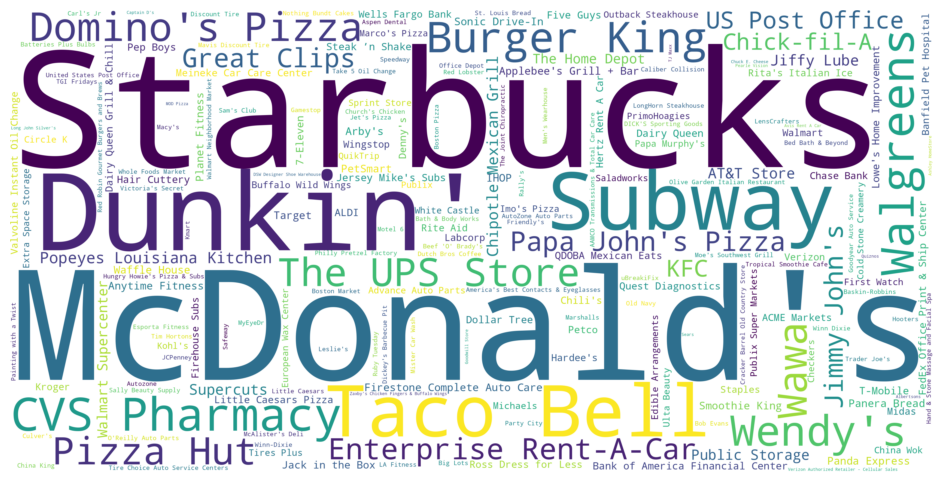

In [ ]:
business.createOrReplaceTempView("tabla_ejemplo")
conteo_valores = spark.sql("SELECT name, COUNT(*) AS conteo FROM tabla_ejemplo GROUP BY name").rdd.collectAsMap()

# crear un objeto WordCloud
wordcloud = WordCloud(background_color ='white',
                      height = 2000, width = 4000, stopwords = STOPWORDS).generate_from_frequencies(conteo_valores)

# mostrar la WordCloud
plt.figure(figsize = (12,6))
plt.imshow(wordcloud, interpolation = 'bilinear')
plt.axis('off')
plt.show()

#### Atributo ```city```

In [ ]:
# Cantidad de ciudades únicas en la columna "city"
cantidad_unicos = business.agg({"city": "approx_count_distinct"}).collect()[0][0]
# mostrar el resultado
print("Cantidad de ciudades únicas:", cantidad_unicos)

Cantidad de ciudades únicas: 1373


In [ ]:
# Conteo de ocurrencias de cada valor en la columna "city"
conteo_valores = business.groupBy("city").agg(count("*").alias("conteo")).orderBy("conteo", ascending = False)
# mostrar el resultado
conteo_valores.limit(5).show()

+------------+------+
|        city|conteo|
+------------+------+
|Philadelphia| 14569|
|      Tucson|  9250|
|       Tampa|  9050|
|Indianapolis|  7540|
|   Nashville|  6971|
+------------+------+



#### Atributo ```state```

In [ ]:
# Cantidad de ciudades únicas en la columna "state"
cantidad_unicos = business.agg({"state": "approx_count_distinct"}).collect()[0][0]
# mostrar el resultado
print("Cantidad de estados únicos donde se ubican los comercios:", cantidad_unicos)

Cantidad de estados únicos donde se ubican los comercios: 29


In [ ]:
# Conteo de ocurrencias de cada valor en la columna "state"
conteo_valores = business.groupBy("state").agg(count("*").alias("conteo")).orderBy("conteo", ascending = False)
# mostrar el resultado
conteo_valores.show()

+-----+------+
|state|conteo|
+-----+------+
|   PA| 34039|
|   FL| 26329|
|   TN| 12056|
|   IN| 11246|
|   MO| 10913|
|   LA|  9924|
|   AZ|  9912|
|   NJ|  8536|
|   NV|  7715|
|   AB|  5573|
|   CA|  5203|
|   ID|  4467|
|   DE|  2265|
|   IL|  2144|
|   TX|     4|
|  NaN|     3|
|   CO|     3|
|   WA|     2|
|   HI|     2|
|   MA|     2|
+-----+------+
only showing top 20 rows



#### Atributo ```categories```

In [ ]:
# Dividir las categorías en una lista y convertir la lista en filas individuales
df = business.withColumn("categories", explode(split("categories", ",")))

# Obtener la cantidad de categorías únicas
cantidad_categorias = df.agg(countDistinct("categories")).collect()[0][0]

# Imprimir la cantidad de categorías únicas
print("Cantidad de categorías únicas: {}".format(cantidad_categorias))

Cantidad de categorías únicas: 2454


In [ ]:
# Dividir las categorías en una lista y convertir la lista en filas individuales
df = business.withColumn("categories", explode(split("categories", ",")))

# Utilizar la función trim para eliminar los espacios en blanco al principio y final de cada palabra
df = df.withColumn("categories", trim(df.categories))

# Obtener un conteo de valores por categoría
conteo_por_categoria = df.groupBy("categories").count().orderBy("count", ascending = False)

# Imprimir el conteo de valores por categoría
conteo_por_categoria.show()

+--------------------+-----+
|          categories|count|
+--------------------+-----+
|         Restaurants|52268|
|                Food|27781|
|            Shopping|24395|
|       Home Services|14356|
|       Beauty & Spas|14292|
|           Nightlife|12281|
|    Health & Medical|11890|
|      Local Services|11198|
|                Bars|11065|
|          Automotive|10773|
|Event Planning & ...| 9895|
|          Sandwiches| 8366|
|American (Traditi...| 8139|
|         Active Life| 7687|
|               Pizza| 7093|
|        Coffee & Tea| 6703|
|           Fast Food| 6472|
|  Breakfast & Brunch| 6239|
|      American (New)| 6097|
|     Hotels & Travel| 5857|
+--------------------+-----+
only showing top 20 rows



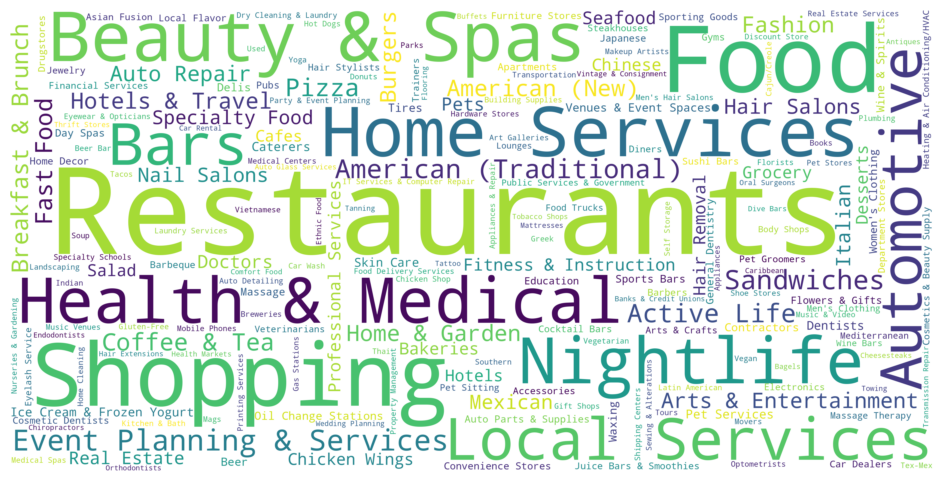

In [ ]:
# convertir el DataFrame a un diccionario
conteo_dict = dict(conteo_por_categoria.rdd.map(lambda x: (x[0], x[1])).collect())

# crear un objeto WordCloud
wordcloud = WordCloud(background_color='white', height = 2000, width = 4000, stopwords=STOPWORDS).generate_from_frequencies(conteo_dict)

# mostrar la WordCloud
plt.figure(figsize = (12,6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

#### Atributo ```attributes```

In [ ]:
# Ver los 5 primeros registros completos de la columna "attributes"
business.select("attributes").limit(5).show(truncate = False)

+--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|attributes                                                                                                                                                                                                                                                                                                                                                                                                                                                                                  |
+-----------------------------------------

## Unión de ```business.pkl``` y ```metadatafinal.parquet```

In [ ]:
path = '/content/drive/MyDrive/Colab Notebooks/PF/metadatafinal.parquet'
metadatafinal = spark.read.format("parquet").option("header", "true").load(path)

#### Cruzando latitud y longitud

In [ ]:
# unir los dos DataFrames utilizando las columnas "latitude" y "longitude"
df1 = business.join(metadatafinal, ["latitude", "longitude"], "inner")

In [ ]:
# contar el número de filas que coinciden
count1 = df1.count()
print("El número de filas que coinciden es:", count1)

El número de filas que coinciden es: 10857


In [ ]:
# mostrar las filas en business que coinciden
df1.limit(5).show()

+----------+-----------+--------------------+-------------------+------------------+--------------+-----+-----------+-----+------------+-------+--------------------+--------------------+--------------------+-------------------+--------------------+--------------------+-----------+--------------------+----------+--------------+-----+--------------------+--------------------+--------------------+--------------------+--------------------+
|  latitude|  longitude|         business_id|               name|           address|          city|state|postal_code|stars|review_count|is_open|          attributes|          categories|               hours|               name|             address|             gmap_id|description|            category|avg_rating|num_of_reviews|price|               hours|                MISC|               state|    relative_results|                 url|
+----------+-----------+--------------------+-------------------+------------------+--------------+-----+-----------+---

In [ ]:
# Tupla con la cantidad de registros y columnas presentes en "df1"
(df1.count(), len(df1.columns))

(10857, 27)

#### Comprobación

In [ ]:
# filtrar las filas con latitud y longitud específicas
latitude = 27.7557668
longitude = -82.7001035
# Verificar si la latitud y longitud se encuentran en metadatafinal
metadatafinal_filtrado = metadatafinal.filter((metadatafinal["latitude"] == lit(latitude)) & (metadatafinal["longitude"] == lit(longitude)))

# Mostrar el resultado
metadatafinal_filtrado.show()

+-------------------+--------------------+--------------------+-----------+----------+-----------+----------------+----------+--------------+-----+--------------------+--------------------+-------------------+--------------------+--------------------+
|               name|             address|             gmap_id|description|  latitude|  longitude|        category|avg_rating|num_of_reviews|price|               hours|                MISC|              state|    relative_results|                 url|
+-------------------+--------------------+--------------------+-----------+----------+-----------+----------------+----------+--------------+-----+--------------------+--------------------+-------------------+--------------------+--------------------+
|Key West Seafood Co|Key West Seafood ...|0x88c2e3e8919a926...|       null|27.7557668|-82.7001035|[Seafood market]|       4.6|           108| null|[[Monday, 10AM–5:...|{[Wheelchair acce...|Closed ⋅ Opens 10AM|[0x88c2e28c2dcedf...|https://www.go

In [ ]:
# Ver los 5 primeros registros completos de la columna "address"
metadatafinal_filtrado.select("address").show(truncate = False)

+-------------------------------------------------------+
|address                                                |
+-------------------------------------------------------+
|Key West Seafood Co, 1449 49th St S, Gulfport, FL 33707|
+-------------------------------------------------------+



In [ ]:
# filtrar las filas con latitud y longitud específicas
latitude = 27.7557668
longitude = -82.7001035
# Verificar si la latitud y longitud se encuentran en business
business_filtrado = business.filter((business["latitude"] == lit(latitude)) & (business["longitude"] == lit(longitude)))

# Mostrar el resultado
business_filtrado.show()

+--------------------+---------------+--------------+--------+-----+-----------+----------+-----------+-----+------------+-------+--------------------+--------------------+-----+
|         business_id|           name|       address|    city|state|postal_code|  latitude|  longitude|stars|review_count|is_open|          attributes|          categories|hours|
+--------------------+---------------+--------------+--------+-----+-----------+----------+-----------+-----+------------+-------+--------------------+--------------------+-----+
|KMSXlznJjoOvXIogV...|Save On Seafood|1449 49th St S|Gulfport|   AZ|      33707|27.7557668|-82.7001035|  4.0|          21|      0|{BikeParking -> T...|Seafood Markets, ...| null|
+--------------------+---------------+--------------+--------+-----+-----------+----------+-----------+-----+------------+-------+--------------------+--------------------+-----+



In [ ]:
# Ver los 5 primeros registros completos de la columna "address"
business_filtrado.select("address").show(truncate = False)

+--------------+
|address       |
+--------------+
|1449 49th St S|
+--------------+



#### Filas que no coinciden

In [ ]:
# Unir los dos DataFrames utilizando las columnas "latitude" y "longitude" con el parámetro "left_anti"
df2 = business.join(metadatafinal, ["latitude", "longitude"], "left_anti")

# Mostrar las filas en business que no coinciden
df2.limit(5).show()

+-------------+--------------+--------------------+--------------------+--------------------+----------------+-----+-----------+-----+------------+-------+--------------------+--------------------+--------------------+
|     latitude|     longitude|         business_id|                name|             address|            city|state|postal_code|stars|review_count|is_open|          attributes|          categories|               hours|
+-------------+--------------+--------------------+--------------------+--------------------+----------------+-----+-----------+-----+------------+-------+--------------------+--------------------+--------------------+
|   27.5582592|   -82.5561601|szluot9mpdIAnUDGi...|Anchor Pools and ...|       810 49th St E|        Palmetto|   NJ|      34221|  2.5|           5|      1|                null|                null|                null|
|   27.5786476|   -82.5410729|2L6gZP_HyI4IpBpFr...|Uppy's Convenient...|7219 US Highway 41 N|        Palmetto|   NV|      34

In [ ]:
# Tupla con la cantidad de registros y columnas presentes en "df2"
(df2.count(), len(df2.columns))

In [ ]:
# Filtrar las filas con latitud y longitud específicas
latitude = 27.5582592
longitude = -82.5561601
# Verificar si la latitud y longitud no se encuentran en metadatafinal
metadatafinal_filtrado = metadatafinal.filter((metadatafinal["latitude"] == lit(latitude)) & (metadatafinal["longitude"] == lit(longitude)))

# Mostrar el resultado
metadatafinal_filtrado.show()

+----+-------+-------+-----------+--------+---------+--------+----------+--------------+-----+-----+----+-----+----------------+---+
|name|address|gmap_id|description|latitude|longitude|category|avg_rating|num_of_reviews|price|hours|MISC|state|relative_results|url|
+----+-------+-------+-----------+--------+---------+--------+----------+--------------+-----+-----+----+-----+----------------+---+
+----+-------+-------+-----------+--------+---------+--------+----------+--------------+-----+-----+----+-----+----------------+---+

